In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
import scipy.special as sp
from statistics import NormalDist

# Downloading the data:

In [26]:
#allow_pickle=True
#  'C:/Users/mo13/Downloads/Mod-13-BO-Capstone-Session/__MACOSX/Mod-13-BO-Capstone-Session/initial_data/function_1/._initial_inputs.npy'
X = np.load(r"C:\Users\mo13\OneDrive\Documents\ML course\project\IMP-PCMLAI-capstone-initial_data\initial_data\function_1\initial_inputs.npy")
Y = np.load(r"C:\Users\mo13\OneDrive\Documents\ML course\project\IMP-PCMLAI-capstone-initial_data\initial_data\function_1\initial_outputs.npy")

Here I'm appending the inputs resulted from the acquisition function below, so everytime I get an query, I add it here to the input "x"

In [27]:
X = np.append(X,[[0, 0.818182], [0.6, 0.65], [0, 1], [0.999999, 0]], axis=0)

Here I'm appending outputs I get from the feedback, so everytime I get the output from the feedback, I add it to the output "Y"

In [28]:
Y = np.append(Y,[6.48e-234, 0.0707318, 0, 0], axis=0)

# Fitting in Guassian Distribution

In [29]:
gpr = GaussianProcessRegressor()
gpr.fit(X, Y)

GaussianProcessRegressor()

# Creating a grid for grid search

In [30]:
# to optimize the acquisition function, we will simply use gridsearch over a space of 10.000 gridpoints
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)

In [31]:
X_grid = []
for i in range(len(x1)):
    for j in range(len(x2)):
        X_grid.append([x1[i], x2[j]])

Implementing the grid search:

In [32]:
from statistics import NormalDist
X_grid = np.array(X_grid)
mean, std = gpr.predict(X_grid, return_std = True)



#####################################################################################################
#Below is my previous approach where I used the probability improvement method for the Acquisition Function (you can ignor it)
#ucb = mean + 1.96 * std
#acquisition_function = []
#eta=0.1
#mx = max([6.48e-234, 0.0707318])
#for k in range(len(X_grid)):
 #   acquisition_function.append(1 - NormalDist(mu = mean[k], sigma = std[k]).cdf(mx + eta))
  #  if  mean[k] > mx:
   #     mx = mean[k]
#acquisition_function = np.array(acquisition_function)

# Applying the "Analytic LogEI"

I have found this approach in "Unexpected Improvements to Expected Improvement for Bayesian Optimization" article (expalined in README file)

Now let's define log1mexp which is $$log( 1 - exp(x) )$$

In [33]:
def log1mexp(x):              
    return np.log(1-np.exp(x))

$log( 1 - exp(x) )$ is used in the acquistion function later

Recall from README file: 

$$c1 = log(2π) / 2$$
$$c2 =  log(π/2) /2$$
$$erfcx(x) = exp(x^{2})erfc(x)$$
where erfc is the complementary error function.
The "Analytic LogEI" acquistion function is: $$ LogEIy^{∗}(x) = log_h((µ(x) − y^{∗})/σ(x)) + log(σ(x))$$
where $log_h(x)$ is calculated below (based on several conditions mentioned in README file and the article (section 4.1)

eta in the code below is ϵ which is chosen to be 0.1. So Let's apply that below:

In [34]:
z = (mean - max(Y)) / std
c1 = np.log(2 * (22/7)) / 2
c2 = np.log((22/7) / 2) / 2
eta=0.1


if (z > -1).any:         # the first condition for log_h     
    log_h = np.log(norm.pdf(z) + z * norm.cdf(z) + 1e-10)    # I added "1e-10" to avoid division by zero
    
elif (-1/np.sqrt(eta) < z).any() and (z <= -1).any():      # the second condition for log_h  
    log_h = -z**2/(2-c1) + log1mexp(np.log(sp.erfcx(-z/np.sqrt(2)) * abs(z)) + c2)

elif (z <= -1 / np.sqrt(eta)).any():    ## the third condition for log_h  
    log_h = -z**2/(2-c1) + 2* np.log(abs(z))

acquisition_function = log_h + np.log(std)
acquisition_function

array([1.89917864, 1.86284271, 1.82611348, ..., 1.78791562, 1.80762979,
       1.82646087])

In [35]:
mean[np.argmax(mean)]

6.751136994920671

In [36]:
acquisition_function[np.argmax(acquisition_function)]

1.899178643631421

# Obtaining the next Query:

In [37]:
idx_max = np.argmax(acquisition_function)
next_query = X_grid[idx_max]
print(next_query.round(6))

[0. 0.]


## Visualizing our data and thinking of the problem

It is important when tackling problems to really think about the best strategy and to do some exploratory data analysis. Let's consider what we know about the problem:

1. From the hints, we expect two modes in the unknown function.

2. From the hints, we know that most of our queries should be zero!

3. The problem is two-dimensional.

4. The problem will have small length-scale (that is, we expect the modes to be very small)

From (3.) we can take advantage, and plot the initial data:

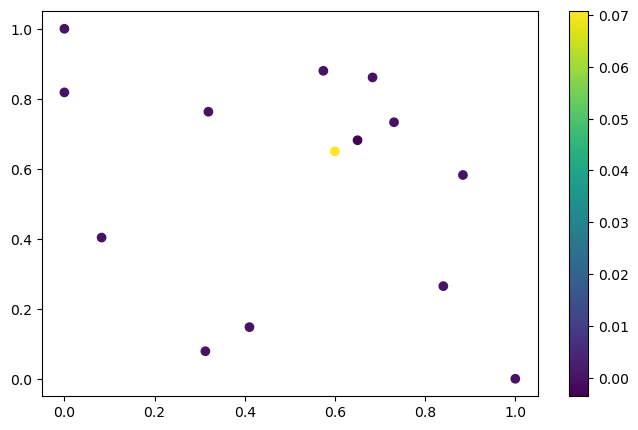

In [20]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(8)
plt.scatter(X[:, 0], X[:, 1], c = Y)
plt.colorbar();

We know that function has two kinds of local maximums, thanks to the hints, we also expect most of our reading to be zero. The fact that we have a perturbation or non-zero value at $x$ = [0.6262626262626263, 0.6767676767676768] means we should be interested in this area. An alternative solution would be to focus only on this area, there are two ways to do this:

1. Run random search in an area restricted around $x$ = [0.6262626262626263, 0.6767676767676768]

2. Solve the UCB in an area restricted around $x$ = [0.6262626262626263, 0.6767676767676768]

Below we provide code for both:

In [21]:
# Random search around an area restricted around $x$ = [0.6262626262626263, 0.6767676767676768]
next_query_x1 = np.random.normal(0.6262626262626263, scale = 0.01)
next_query_x2 = np.random.normal(0.6767676767676768, scale = 0.01)
print('Next query Random: ', [next_query_x1, next_query_x2])

Next query Random:  [0.633860775301744, 0.6697138552648901]


In [22]:
# Using a restricted UCB
gpr = GaussianProcessRegressor()
gpr.fit(X, Y)

GaussianProcessRegressor()

In [23]:
# to optimize the acquisition function, we will simply use gridsearch over a space of 10.000 gridpoints
x1 = np.linspace(0.6, 0.65, 100)
x2 = np.linspace(0.65, 0.69, 100)

In [24]:
X_grid = []
for i in range(len(x1)):
    for j in range(len(x2)):
        X_grid.append([x1[i], x2[j]])

In [39]:
X_grid = np.array(X_grid)
mean, std = gpr.predict(X_grid, return_std = True)
ucb = mean + 1.96 * std

In [40]:
idx_max = np.argmax(ucb)
next_query = X_grid[idx_max]
print('Next query UCB: ', next_query)

Next query UCB:  [0.65 0.65]


Doing this every week, we expect to be able to find the first of the two modes! This should would be enough to provide a good solution to the problem. To really verify if we found the maximum, we would need to find a second mode, however, we may be unlucky and simply never find it. This is an important part of Machine Learning: in theory we might want optimal, perfect solutions, but in practice most of the advancements can be done with simple solutions and careful consideration of the data available to us.